In [1]:
import os
import pandas as pd

import numpy as np
import scanpy as sc
import mudata as md
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
mdata = md.read_h5mu('../../results/preprocessing_data/multiome_train.h5mu')
mdata

MuData object with n_obs × n_vars = 25551 × 158205
  var:	'gene_id', 'feature_type', 'genome', 'interval'
  2 modalities
    rna:	25551 x 22787
      obs:	'cell_type', 'donor_id'
      var:	'gene_id', 'feature_type', 'genome', 'interval'
      layers:	'counts', 'normalized_count'
    atac:	25551 x 135418
      obs:	'cell_type', 'donor_id'
      var:	'gene_id', 'feature_type', 'genome', 'interval'
      layers:	'counts', 'normalized_count'

In [3]:
adata = mdata['rna']
adata.layers['counts'] = adata.X.copy()

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata, n_comps=15)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

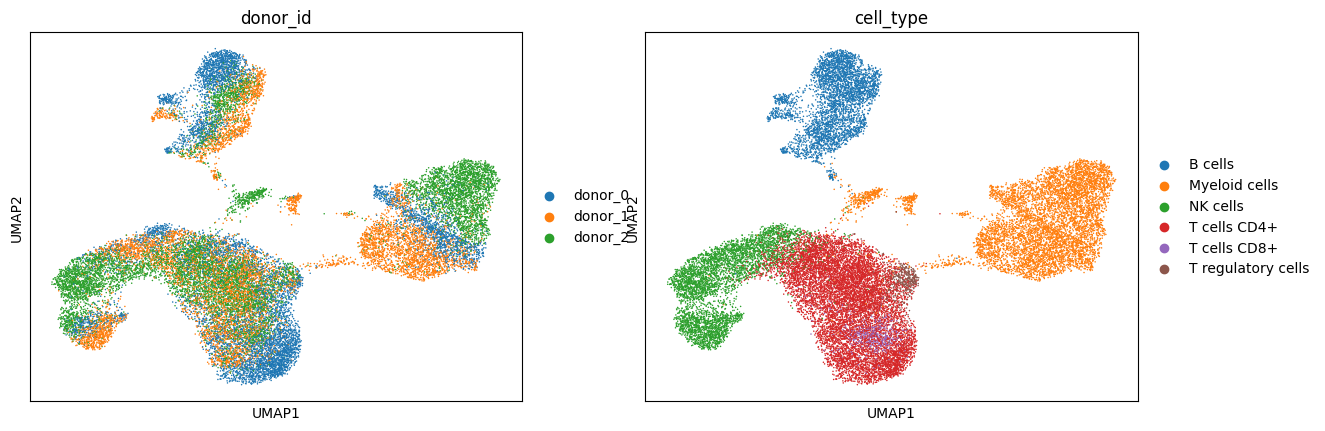

In [5]:
sc.pl.umap(adata, color=['donor_id', 'cell_type'])

In [6]:
# batch correction
from scipy.cluster.vq import kmeans2
import harmonypy as hm
import numpy as np

def cluster_fn(data, K):
    centroid, label = kmeans2(data, K, minit='++')
    return centroid

harmony_out = hm.run_harmony(adata.obsm['X_pca'].astype(np.float64), 
                             adata.obs, ['donor_id'], cluster_fn=cluster_fn)

adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

2023-10-27 20:38:06,327 - harmonypy - INFO - Iteration 1 of 10
2023-10-27 20:38:14,732 - harmonypy - INFO - Iteration 2 of 10
2023-10-27 20:38:23,197 - harmonypy - INFO - Iteration 3 of 10
2023-10-27 20:38:31,251 - harmonypy - INFO - Iteration 4 of 10
2023-10-27 20:38:39,409 - harmonypy - INFO - Iteration 5 of 10
2023-10-27 20:38:48,017 - harmonypy - INFO - Iteration 6 of 10
2023-10-27 20:38:51,412 - harmonypy - INFO - Iteration 7 of 10
2023-10-27 20:38:54,474 - harmonypy - INFO - Converged after 7 iterations


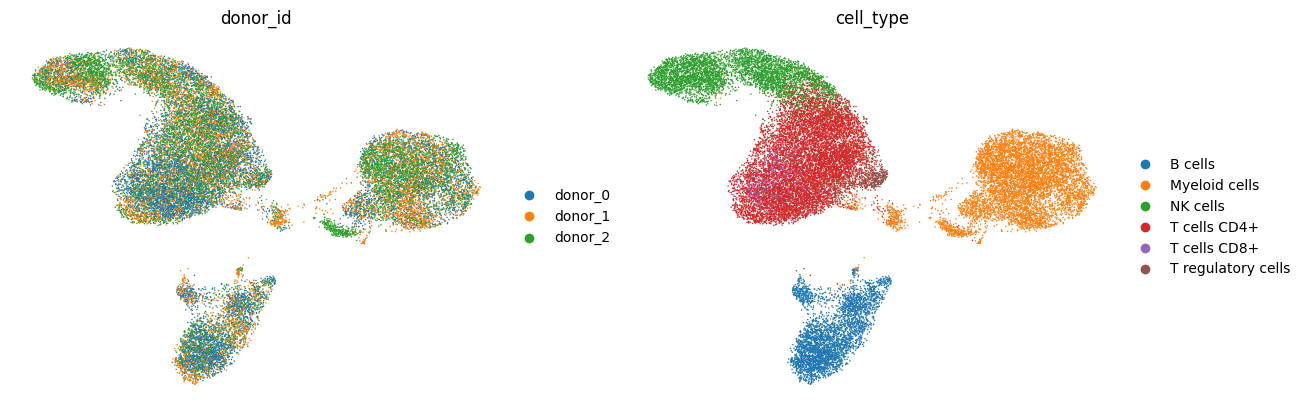

In [7]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['donor_id', 'cell_type'], frameon=False)

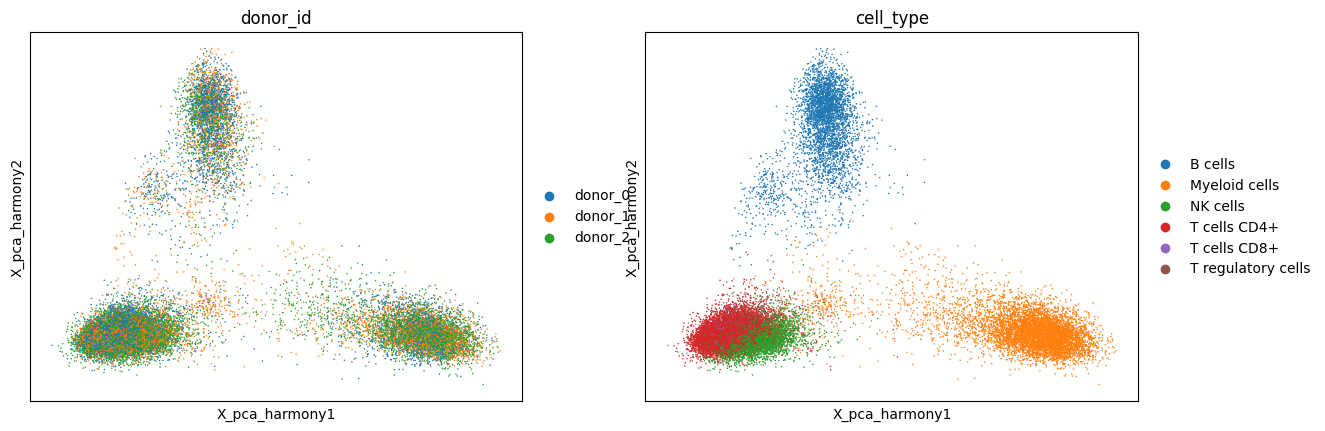

In [8]:
sc.pl.embedding(adata, basis='X_pca_harmony', color=['donor_id', 'cell_type'])

In [9]:
df_pca = pd.DataFrame(data=adata.obsm['X_pca_harmony'], columns=[f'PCA_{i}' for i in range(adata.obsm['X_pca_harmony'].shape[1])]) 

In [10]:
df_pca

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14
0,-0.215881,9.332933,0.116084,-1.525372,1.337973,-0.393189,-0.082104,-0.518781,-0.234452,0.287347,0.974224,0.420439,-0.363977,-0.596570,0.439215
1,-4.146904,-1.057348,-0.729756,-0.703393,0.446125,-1.503014,-0.552746,-0.565035,-0.187102,0.174341,0.099738,1.800329,-0.219261,1.624782,-0.477685
2,-2.865278,-0.961758,1.874696,1.157630,0.386289,-0.498042,-0.660684,-0.195192,0.244855,-0.777105,1.150625,1.695584,0.015092,1.421207,-0.572887
3,-0.292368,7.474497,-0.388259,-0.517969,0.739883,0.600973,-0.350883,-0.359969,-0.271681,-0.169503,-0.282496,0.612610,0.248946,-1.064036,0.701583
4,-2.904259,-0.993430,1.745324,0.140641,0.880162,-0.248955,-0.239365,-1.288766,-0.664317,-0.799170,0.148148,-0.058967,-1.265312,-0.447455,-1.310088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25546,-3.722233,-0.224900,-2.388361,-0.399259,0.165345,0.564489,0.380453,0.043058,0.107092,-0.173894,0.309890,-0.458635,0.713731,0.069350,0.534268
25547,-1.910027,-0.326293,-0.830446,0.738545,-1.468782,-0.818186,0.118955,0.901890,0.889251,1.392644,0.153945,-0.648607,-0.447105,-0.293599,-0.731355
25548,10.163483,-1.674821,-1.048620,1.579389,1.695278,0.136848,0.205204,-1.403690,2.044546,1.200130,3.268830,-1.962690,-2.844408,0.845178,2.353232
25549,-3.234238,-1.217743,3.156966,-1.215380,-0.210152,-1.093643,-0.081749,-0.766860,0.314575,0.143471,-0.154303,0.649539,-1.109451,0.577545,-0.082188


In [11]:
df_pca['cell_type'] = adata.obs['cell_type'].values

In [12]:
grouped = df_pca.groupby('cell_type')

In [13]:
df_mean = grouped.mean()

In [14]:
df_mean

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14
cell_type,,,,,,,,,,,,,,,
B cells,-0.116944,6.797616,0.141448,-0.010329,0.209467,-0.110409,-0.054209,-0.089452,0.014788,0.159434,-0.066586,-0.215790,0.092058,0.071354,-0.085981
Myeloid cells,7.054492,-1.097528,-0.381173,0.438082,-0.087500,0.103286,-0.078048,0.022110,-0.029509,-0.043606,0.012369,0.094361,-0.003509,0.040294,-0.011380
NK cells,-2.523751,-1.458417,3.552889,0.187137,0.245377,0.247587,-0.047436,-0.024522,-0.069554,-0.238218,0.124646,-0.017130,-0.005766,0.075384,-0.106673
T cells CD4+,-3.527583,-1.223455,-1.407943,-0.087279,-0.105173,-0.166271,-0.014173,-0.047556,0.016597,0.097814,0.064968,0.024253,0.095496,-0.021572,0.030785
T cells CD8+,-3.500110,-1.045721,-1.653474,-0.132634,-0.041570,0.647838,0.107944,-0.489130,-0.747345,-0.895747,-0.213665,-0.943113,-0.322815,0.163602,0.141510
T regulatory cells,-2.853311,-0.717639,-0.796173,0.298059,-0.185584,0.196195,0.312839,1.443267,1.211957,0.817052,-0.356938,0.976761,0.267238,-0.386560,0.694341


<Axes: xlabel='PCA_0', ylabel='PCA_1'>

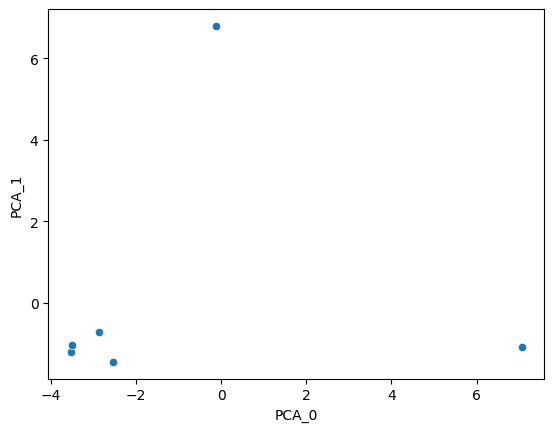

In [15]:
sns.scatterplot(df_mean, x='PCA_0', y='PCA_1')

In [16]:
df_mean.to_csv('../../results/cell_type_embedding/rna_pca.csv')